## Create Optimal Hotel Recommendations

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
#load data with random rows to reduce size
train = pd.read_csv('train2.csv', nrows = 50000)

# look at head of data
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [3]:
# look at infor for columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  50000 non-null  object 
 1   site_name                  50000 non-null  int64  
 2   posa_continent             50000 non-null  int64  
 3   user_location_country      50000 non-null  int64  
 4   user_location_region       50000 non-null  int64  
 5   user_location_city         50000 non-null  int64  
 6   orig_destination_distance  30998 non-null  float64
 7   user_id                    50000 non-null  int64  
 8   is_mobile                  50000 non-null  int64  
 9   is_package                 50000 non-null  int64  
 10  channel                    50000 non-null  int64  
 11  srch_ci                    49971 non-null  object 
 12  srch_co                    49971 non-null  object 
 13  srch_adults_cnt            50000 non-null  int

In [4]:
# remove column do to many missing values
del train['orig_destination_distance']

# drop rows with low amount of na values for search dates
train = train.dropna()

In [5]:
# Data transformation
#  encode categorical values with labels
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = train.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    train[i] = d[i].transform(train[i])

<AxesSubplot:>

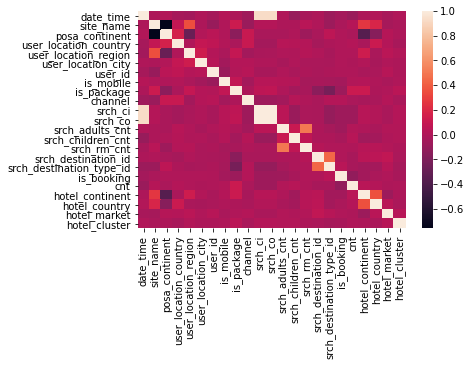

In [6]:
# check for correlation between vraibles 

import seaborn as sns
%matplotlib inline
corr = train.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [7]:
#set features and predicted value
features = train[train.columns.difference(['is_booking'])]
labels = train['is_booking']

In [8]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

#set bin size
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

# Weight of Evidence and Information Value function

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [9]:
# Execute funtioon for Weight of Evidence and Information Value
final_iv, IV = data_vars(train, train.is_booking)

C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#rename var name as index 
IV = IV.rename(columns={'VAR_NAME':'index'})

In [11]:
# sort index accortdingly 
IV.sort_values(['IV'],ascending=0)

,index,IV
1,cnt,8.467800e-01
8,is_package,8.761102e-02
14,srch_co,5.592286e-02
13,srch_ci,5.393410e-02
4,hotel_continent,4.322524e-02
16,srch_destination_type_id,3.195573e-02
7,is_mobile,2.494686e-02
2,date_time,2.116989e-02
12,srch_children_cnt,1.627353e-02
5,hotel_country,1.223889e-02


In [12]:
#calculate Variable Importance

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9998999419663405


In [13]:
#show importance per varible 
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
2,date_time,0.304972
3,hotel_cluster,0.084234
14,srch_co,0.076692
13,srch_ci,0.073913
15,srch_destination_id,0.059648
19,user_location_city,0.056187
18,user_id,0.054733
6,hotel_market,0.053901
21,user_location_region,0.044809
1,cnt,0.033648


In [14]:
#implment Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

Selected[Selected['RFE'] == True]

C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

,index,RFE
0,channel,True
1,cnt,True
2,date_time,True
3,hotel_cluster,True
4,hotel_continent,True
5,hotel_country,True
6,hotel_market,True
7,is_mobile,True
8,is_package,True
9,posa_continent,True


In [15]:
# calculate Variable Importance with Extratrees Classifier
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.02323341 0.06525737 0.44257635 0.07279112 0.01047728 0.01427598
 0.03262215 0.00467701 0.00667415 0.00534718 0.00953431 0.02532822
 0.01263347 0.05313733 0.0562246  0.03321976 0.01616626 0.00987581
 0.0310144  0.03288611 0.01284899 0.02919877]


In [16]:
#create index with variables for results
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)
FI = FI.reset_index()
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
2,date_time,0.442576
3,hotel_cluster,0.072791
1,cnt,0.065257
14,srch_co,0.056225
13,srch_ci,0.053137
15,srch_destination_id,0.033220
19,user_location_city,0.032886
6,hotel_market,0.032622
18,user_id,0.031014
21,user_location_region,0.029199


In [17]:
#conduct Chi Square anaysis

df1 = train.copy()

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

features1 = df1[df1.columns.difference(['is_booking'])]
labels1 = df1['is_booking']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features1, labels1)

import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)



[    45.50195615   1981.74058607 633033.43112907    504.95309967
    123.07883796    148.28496321   1954.50901313     69.45957316
    206.76938989      0.69029447    115.33668643     73.63092219
     64.3067425   19888.63639555  20573.38899624  10560.88115926
    211.70381758      0.39589811    137.42719019   1757.6288433
     18.25827328    215.52143366]


In [18]:
#create index with variables for results
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)

chi_sq = chi_sq.reset_index()

chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
2,date_time,633033.43
14,srch_co,20573.39
13,srch_ci,19888.64
15,srch_destination_id,10560.88
1,cnt,1981.74
6,hotel_market,1954.51
19,user_location_city,1757.63
3,hotel_cluster,504.95
21,user_location_region,215.52
16,srch_destination_type_id,211.70


In [19]:
#conduct Linear feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

#create index with variables for results
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

l1 = l1.reset_index()

l1[l1['L1'] == True]

C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,index,L1
0,channel,True
1,cnt,True
3,hotel_cluster,True
4,hotel_continent,True
7,is_mobile,True
8,is_package,True
9,posa_continent,True
10,site_name,True
11,srch_adults_cnt,True
12,srch_children_cnt,True


In [20]:
# merge results from feature anbalysis into single graph

from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

final_results.head()

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
0,channel,0.00,0.02,True,0.02,45.50,True
1,cnt,0.85,0.03,True,0.07,1981.74,True
2,date_time,0.02,0.30,True,0.44,633033.43,False
3,hotel_cluster,0.01,0.08,True,0.07,504.95,True
4,hotel_continent,0.04,0.01,True,0.01,123.08,True


In [21]:
#score varibles based on how ell they scored in feature selection analysis 

columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

score_table['final_score'] = score_table.sum(axis=1)

score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
13,srch_ci,1,1,1,1,1,1,6
14,srch_co,1,1,1,1,1,1,6
1,cnt,1,0,1,1,1,1,5
2,date_time,0,1,1,1,1,0,4
3,hotel_cluster,0,1,1,0,1,1,4
4,hotel_continent,1,0,0,0,1,1,3
8,is_package,1,0,0,0,1,1,3
15,srch_destination_id,0,1,0,1,1,0,3
0,channel,0,0,0,0,1,1,2
20,user_location_country,0,0,0,0,1,1,2


C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


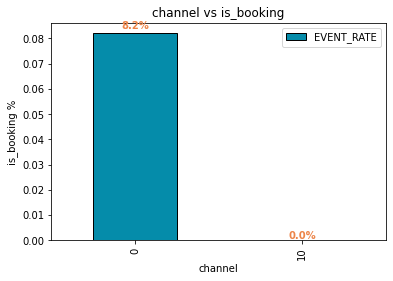

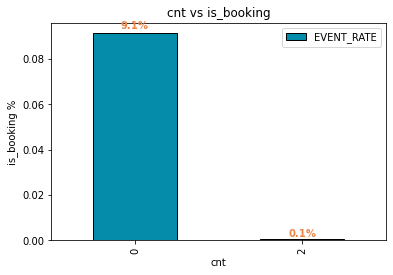

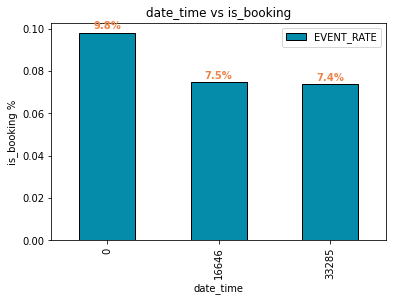

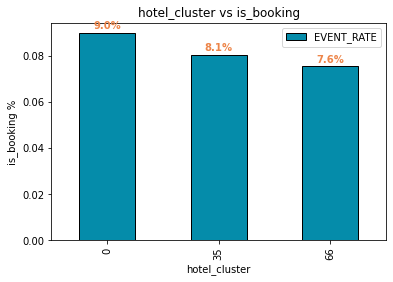

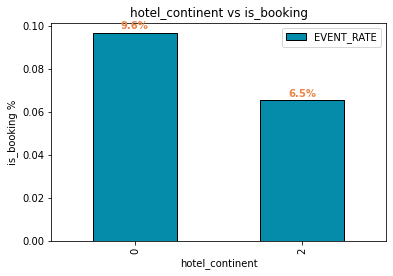

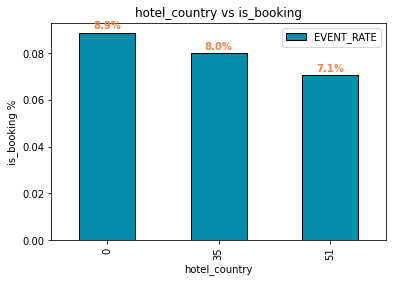

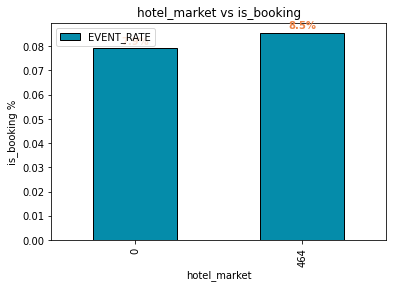

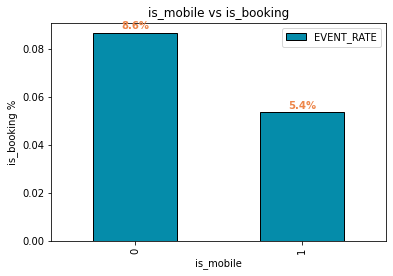

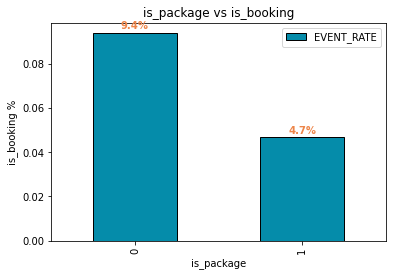

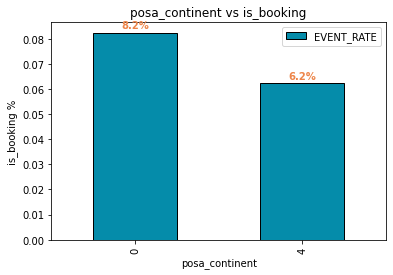

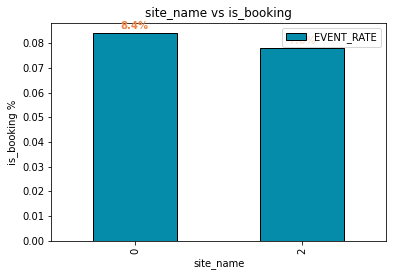

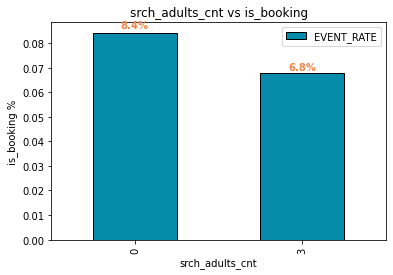

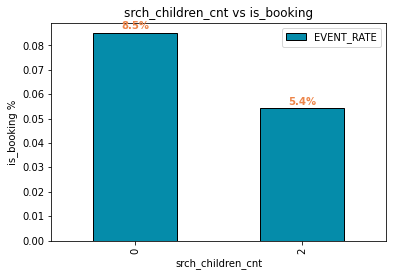

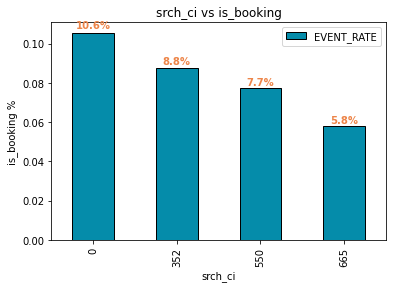

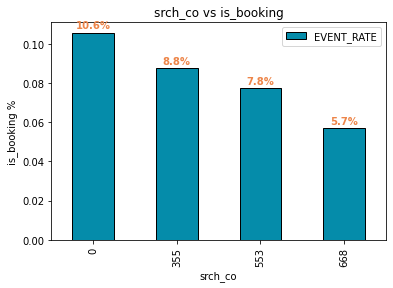

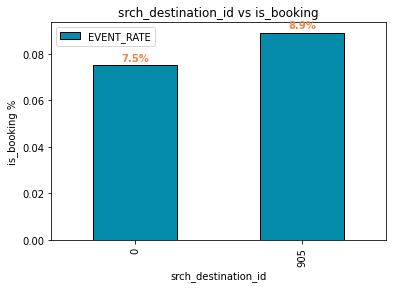

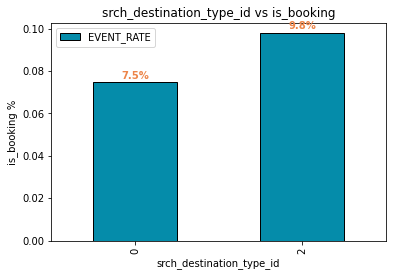

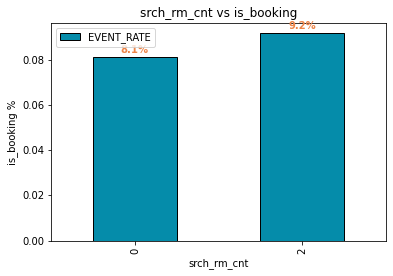

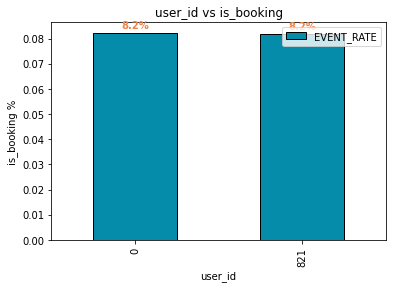

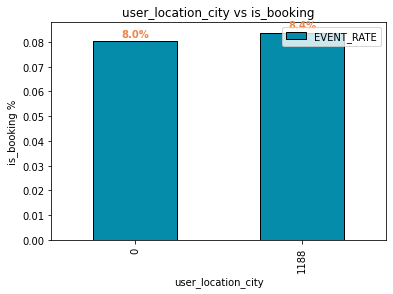

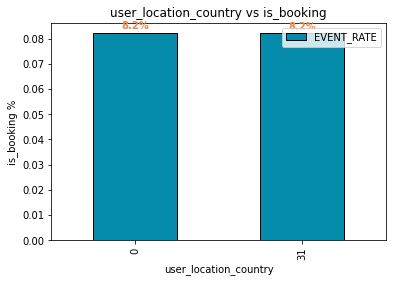

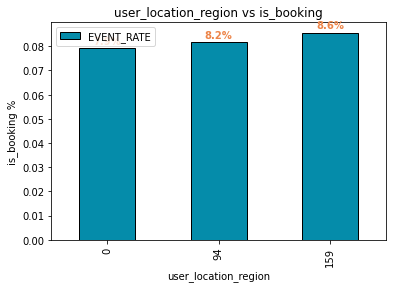

In [22]:
# look at bivariate plot for independent variables vs booking variable

bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['is_booking'])
final_iv = final_iv[(final_iv.VAR_NAME != 'is_booking')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('is_booking'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('is_booking') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

In [23]:
# Calculate Multicollinearity Variance Inflation Factor of features 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\dmeiners\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
# split and train models based on Variance Inflation Factor of features 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['is_booking']
features_test = test[list(vif['Features'])]
label_test = test['is_booking']

In [25]:
# Random forest prediction
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

In [26]:
# optimize Random forest prediction
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   43.9s finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 64, 118, 173, 227,
                                                         282, 336, 391, 445,
                                                         500]},
                   random_state=42, verbose=2)

In [27]:
#observe performance of rando forest prediction
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,27577,0
1,0,2405


## Conclusion

The results suggest a fairly effective model with random forest for predicting whether a person will book based on features which are important. Next steps for implementation of this model would be to subset the input data to show which users would book given a hotel cluster id and features that correlate with the users that book.  

In [28]:
References
https://github.com/Sundar0989/Variable-Selection-Using-Python/blob/master/Variable%20Selection%20using%20Python%20-%20Vote%20based%20approach.ipynb
https://towardsdatascience.com/end-to-end-python-framework-for-predictive-modeling-b8052bb96a78

SyntaxError: invalid syntax (<ipython-input-28-172cb5a75310>, line 2)